# Linear Models and Interpretability

This notebook explores the interpretability of a linear models using a Kaggle toy dataset.

## Exploratory Data Analysis 

This section covers an exploratory analysis of the dataset. 

In [1]:
import numpy as np 
import pandas as pd
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns

### Dataset

The target of the analysis is the Kaggle **Telco Customer Churn** dataset (https://www.kaggle.com/datasets/blastchar/telco-customer-churn/data). From the dataset page on Kaggle: 

**Context**
*"Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs." [IBM Sample Data Sets]*

**Content**
*Each row represents a customer, each column contains customer’s attributes described on the column Metadata.*

**The data set includes information about:**
- *Customers who left within the last month – the column is called Churn*
- *Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies*
- *Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges*
- *Demographic info about customers – gender, age range, and if they have partners and dependents*

In [ ]:
# NOTE: this cell straight from the Kaggle project
import kagglehub

# Download latest version
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)

/Users/jason/Local/school/590/assignment2/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/jason/.cache/kagglehub/datasets/blastchar/telco-customer-churn/versions/1


: 

In [ ]:
!ls $path

WA_Fn-UseC_-Telco-Customer-Churn.csv


: 

In [ ]:
df = pd.read_csv(path + f"/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


: 

In [6]:
assert(len(df.customerID.unique()) == len(df))

The dataset provides features about a customer, with one row per customer (who are each uniquely identified by the `customerID` column), and are now redundant given our index. 

In [7]:
df.drop(['customerID'], axis=1, inplace=True) 

### Characterize Predictors

Next we'll inspect the predictor variables and characterize their distribution as well as their relationship to one another. To do this we need to decompose and re-encode the categoricals in a method suitable for numerical comparisons. 

In [8]:
from sklearn.preprocessing import binarize, label_binarize, OneHotEncoder

In [9]:
for col in df.columns: 
    if df[col].dtype == 'object': 
        print(f"{col}: {df[col].unique()}")

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
TotalCharges: ['29.85' '1889.5' '108.15' ... '346.45' '306.6' '6844.5']
Churn: ['No' 'Yes']


We need to transform our features to support this analysis as well as later modeling. Copy the DF so we can retain both representations. 

In [10]:
dfm = df.copy()

In [11]:
dfm.gender = label_binarize(df.gender, classes=df.gender.unique())
dfm.Partner = label_binarize(df.Partner, classes=df.Partner.unique())
dfm.Dependents = label_binarize(df.Dependents, classes=df.Dependents.unique())
dfm.PhoneService = label_binarize(df.PhoneService, classes=df.PhoneService.unique())
dfm.PaperlessBilling = label_binarize(df.PaperlessBilling, classes=df.PaperlessBilling.unique())
dfm.Churn = label_binarize(df.Churn, classes=df.Churn.unique())

In [12]:
def onehot_encode(df, column, drop_source=True): 
    """
    One-hot encode the target column
    """
    enc = OneHotEncoder(handle_unknown='error', sparse_output=False)
    onehot = enc.fit_transform(df.loc[:,[column]])
    for i, feature in enumerate(enc.get_feature_names_out()): 
        df[feature] = onehot[:,i]

    return df.drop([column], axis=1) if drop_source else df

In [13]:
dfm = onehot_encode(dfm, 'MultipleLines')
dfm = onehot_encode(dfm, 'InternetService')
dfm = onehot_encode(dfm, 'OnlineSecurity')
dfm = onehot_encode(dfm, 'OnlineBackup')
dfm = onehot_encode(dfm, 'DeviceProtection')
dfm = onehot_encode(dfm, 'TechSupport')
dfm = onehot_encode(dfm, 'StreamingTV')
dfm = onehot_encode(dfm, 'StreamingMovies')
dfm = onehot_encode(dfm, 'Contract')
dfm = onehot_encode(dfm, 'PaymentMethod')

In [14]:
dfm.TotalCharges = df.TotalCharges.apply(lambda x: 0 if x==' ' else x)
dfm.TotalCharges = dfm.TotalCharges.astype(float)

In [15]:
dfm

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,0,0,1,0,0,29.85,29.85,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,0,1,0,34,1,1,56.95,1889.50,0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1,0,1,0,2,1,0,53.85,108.15,1,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,0,1,0,45,0,1,42.30,1840.75,0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0,0,1,0,2,1,0,70.70,151.65,1,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,0,1,24,1,0,84.80,1990.50,0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
7039,0,0,0,1,72,1,0,103.20,7362.90,0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
7040,0,0,0,1,11,0,0,29.60,346.45,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
7041,1,1,0,0,4,1,0,74.40,306.60,1,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


**Distribution** 
Here we plot a histogram of the categoricals and continuous predictors to get an appreciation for the distribution of each. 

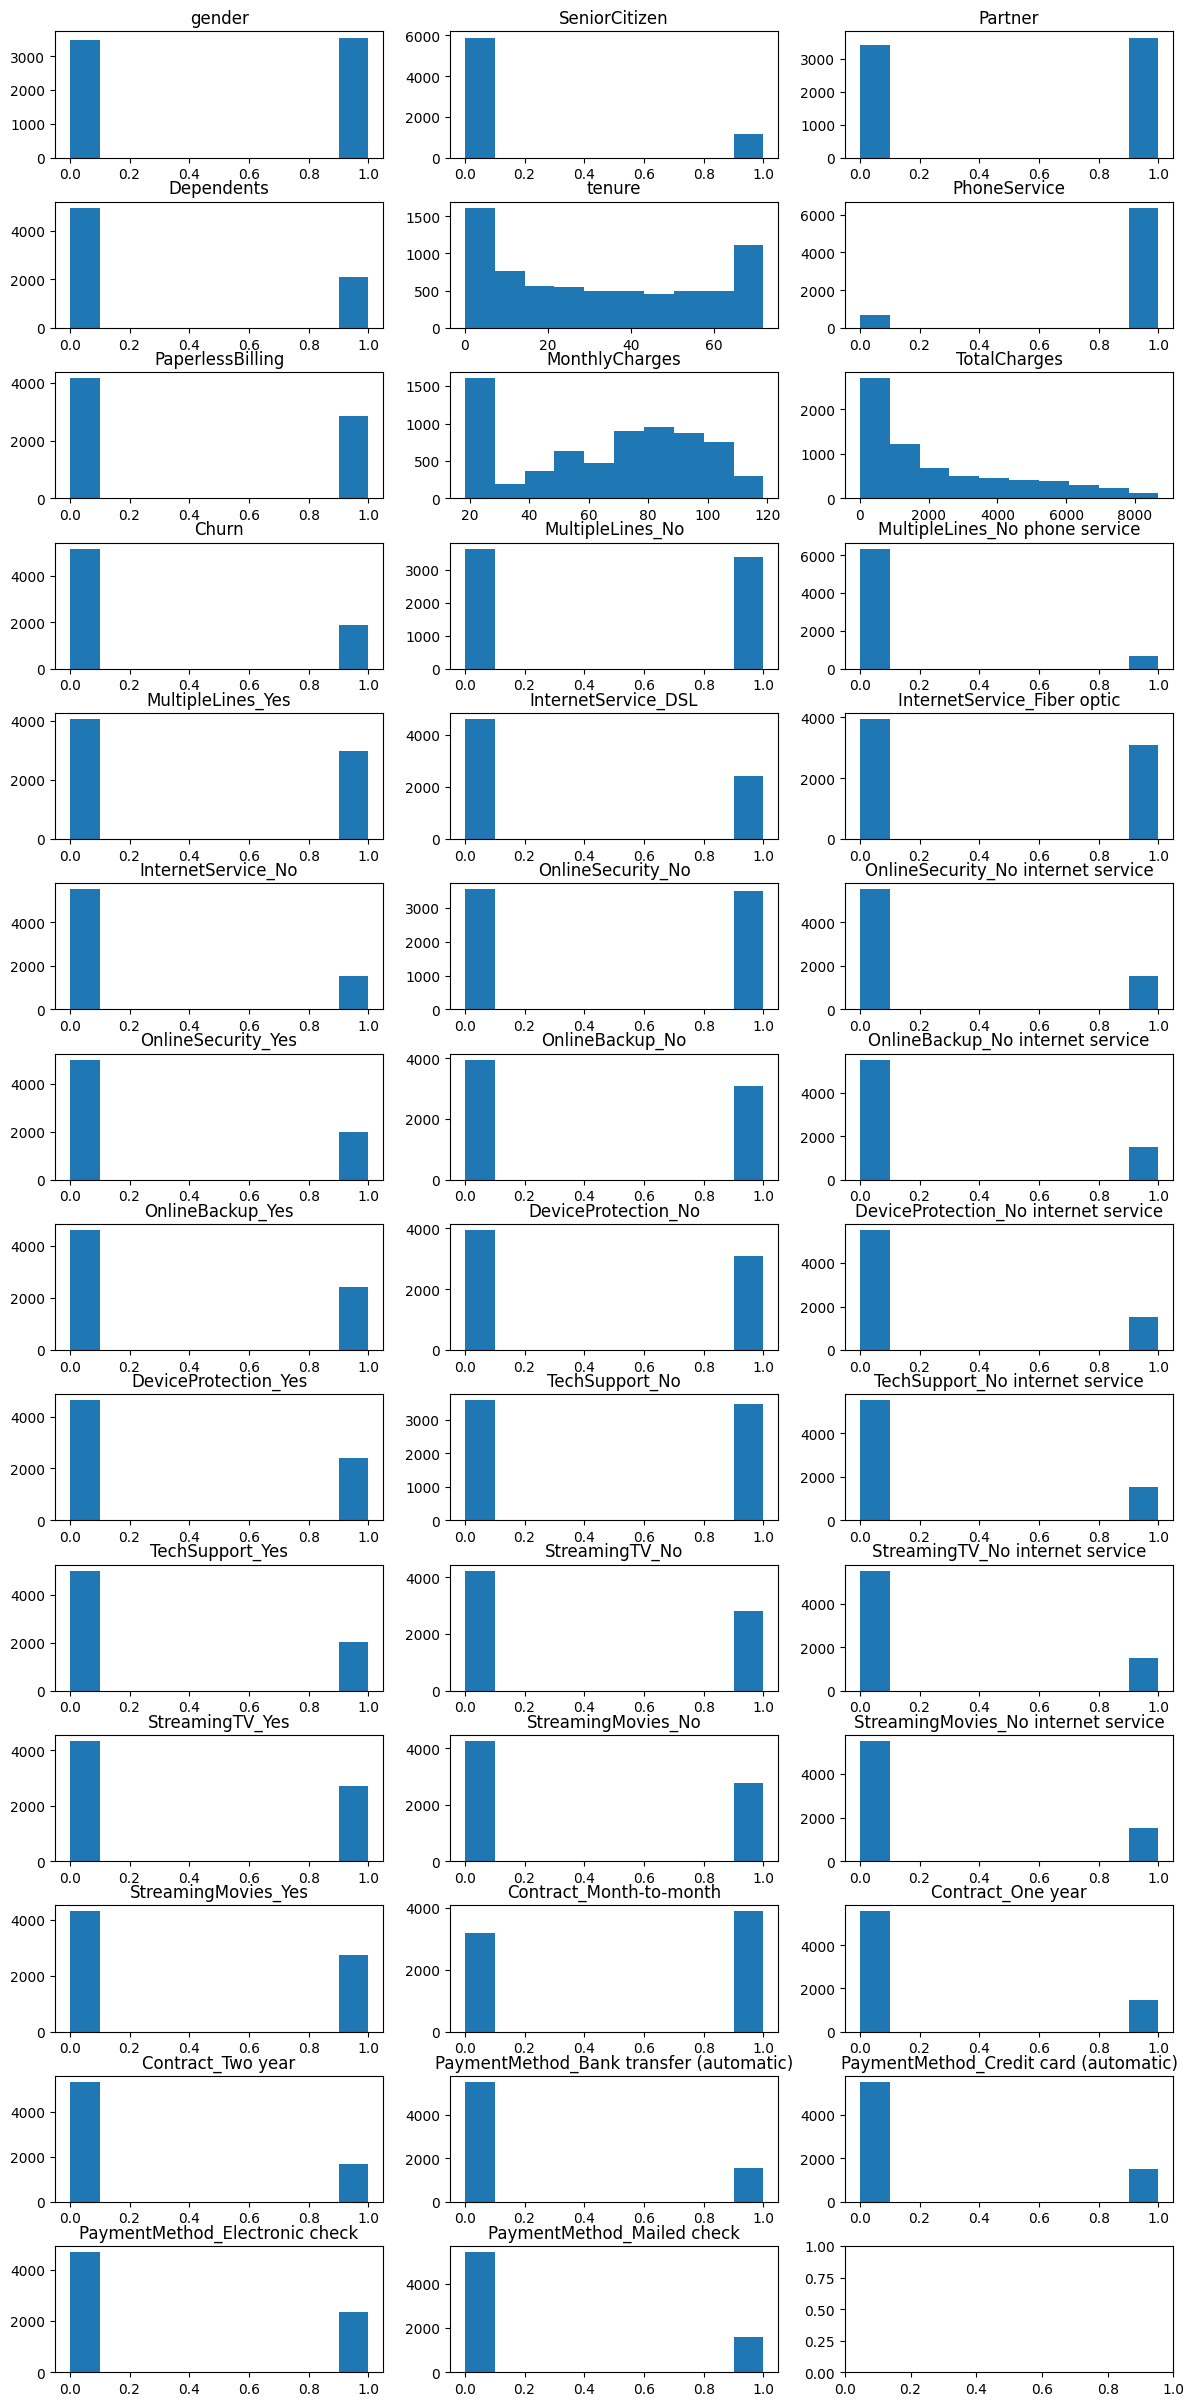

In [16]:
# Plot the distribution of all variables and the target
features = dfm.columns
h = 14
w = 3
fig, axs = plt.subplots(h,w, figsize=(12,24))
fig.tight_layout()
for i, feature in enumerate(features): 
     row = i // w
     col = i % w
     axs[row, col].hist(dfm[feature])
     axs[row, col].set_title(feature)
     
plt.show()

While it's useful to understand the degree to which the categorical classes are balanced, there's not much of an intervention to do here as we're only studying model interpretability. 

**Linearity Check** 

Inspect the predictors' relationship with the target. 

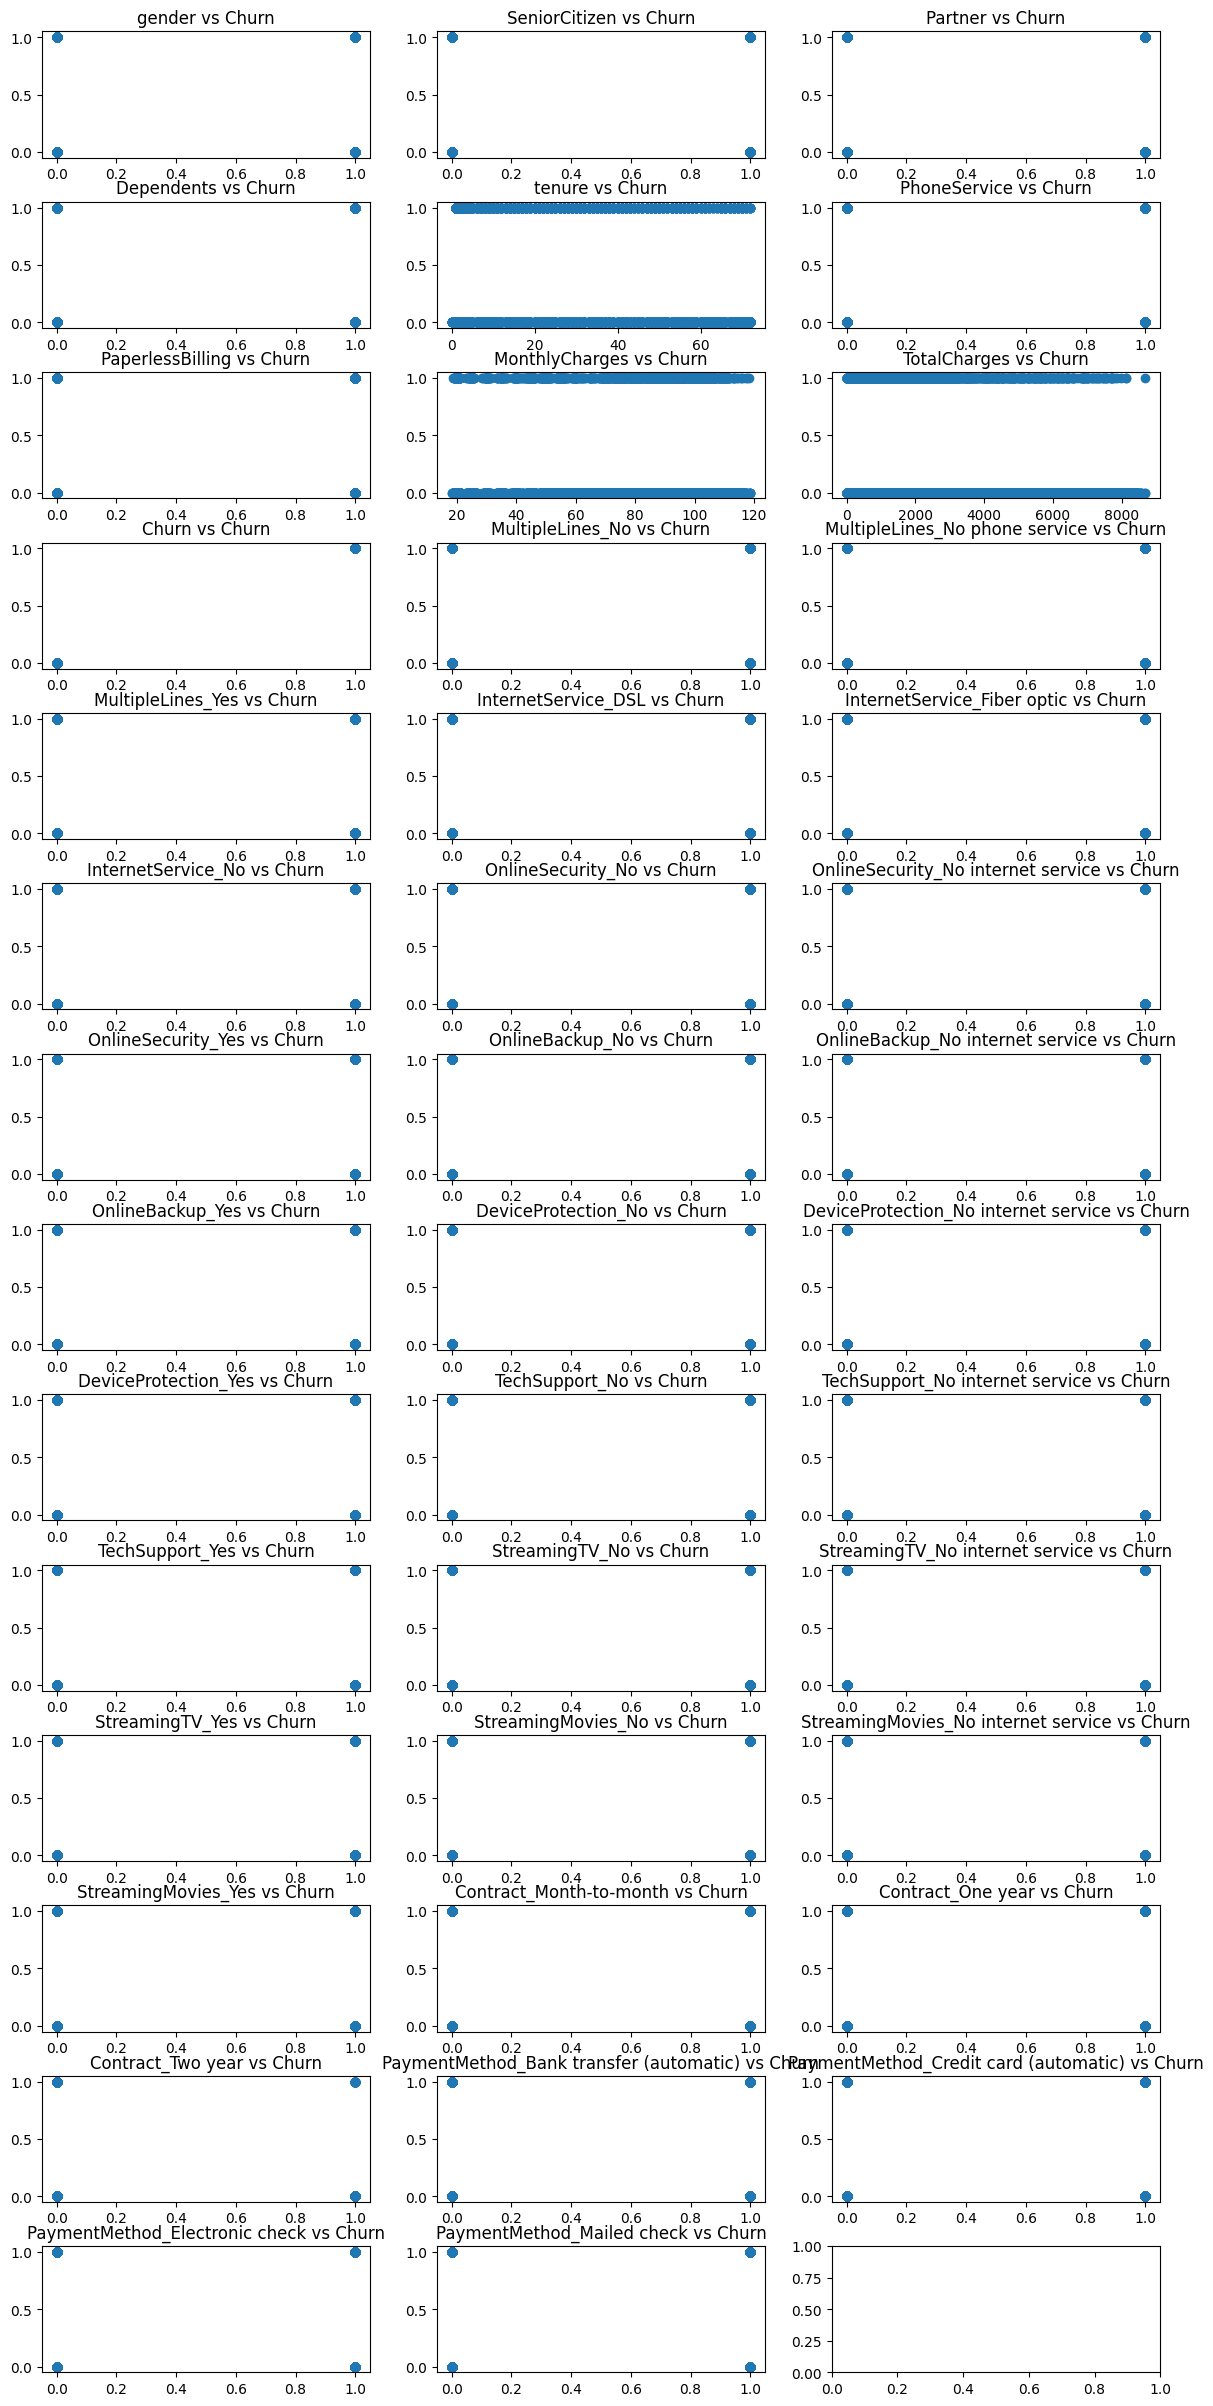

In [17]:
features = dfm.columns
target = "Churn"
h = 14
w = 3
fig, axs = plt.subplots(h,w, figsize=(12,24))
fig.tight_layout()
for i, feature in enumerate(features): 
     row = i // w
     col = i % w
     axs[row, col].scatter(x=dfm[feature], y=dfm[target])
     axs[row, col].set_title(f"{feature} vs {target}")
     
plt.show()
     

The bulk of our predictors are categoricals as is our target. Even after unpacking to more precisely represent the respective dimensions, we 

**Independence** 

To test independence we need a numerical representation of each feature. Inventory the unique values and encode using the appropriate method (binarize or one-hot)

In [18]:
cm = dfm.corr()


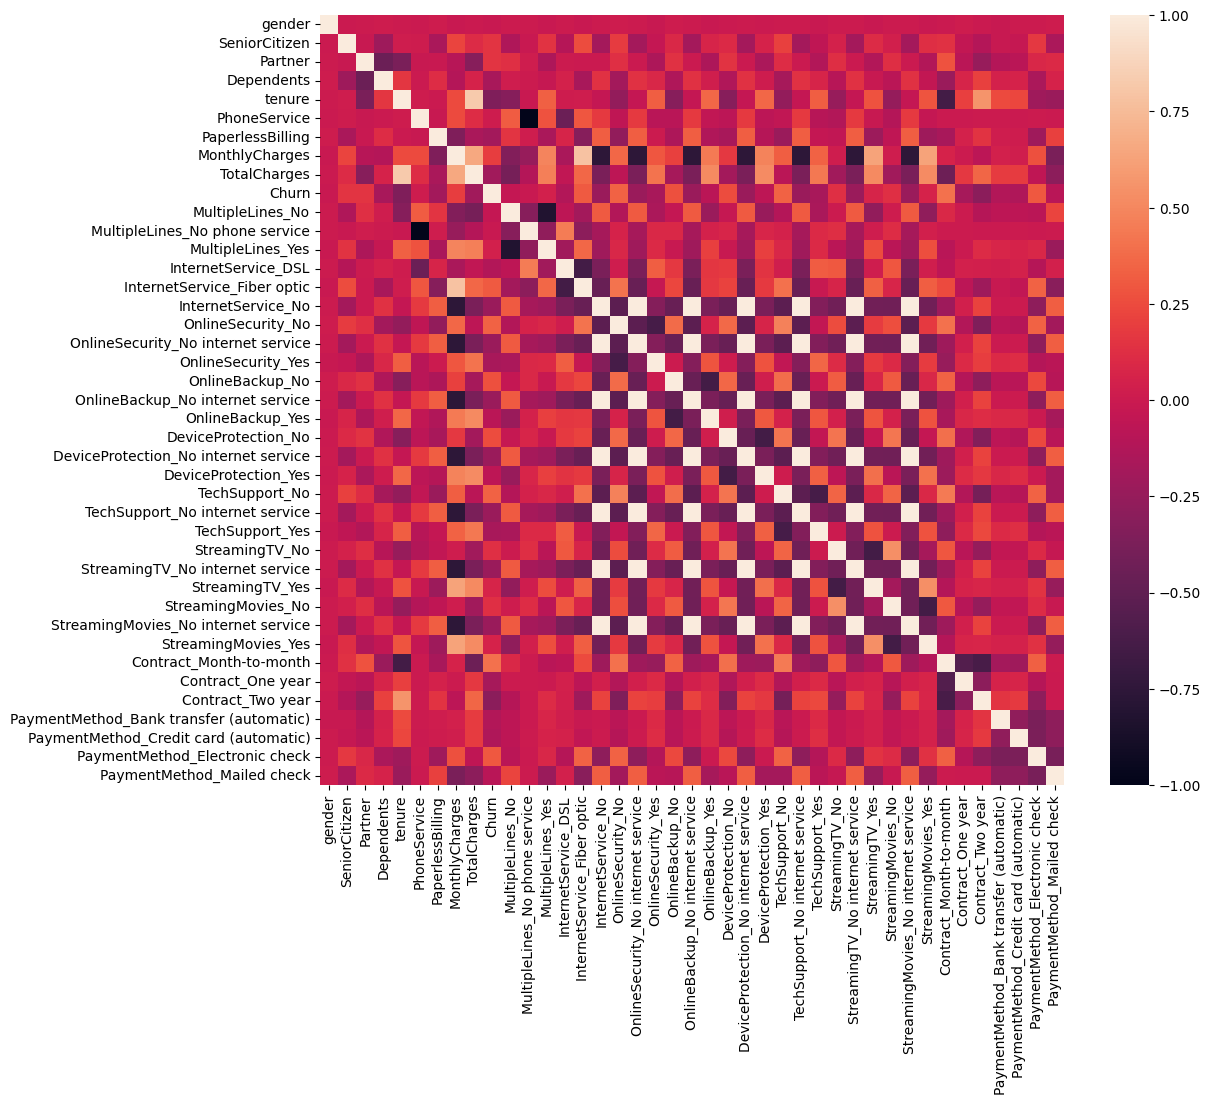

In [19]:
plt.figure(figsize=(12, 10))
_ = sns.heatmap(cm)

With an idea of what correlations exist, we threshold to determine the most problematic features. 

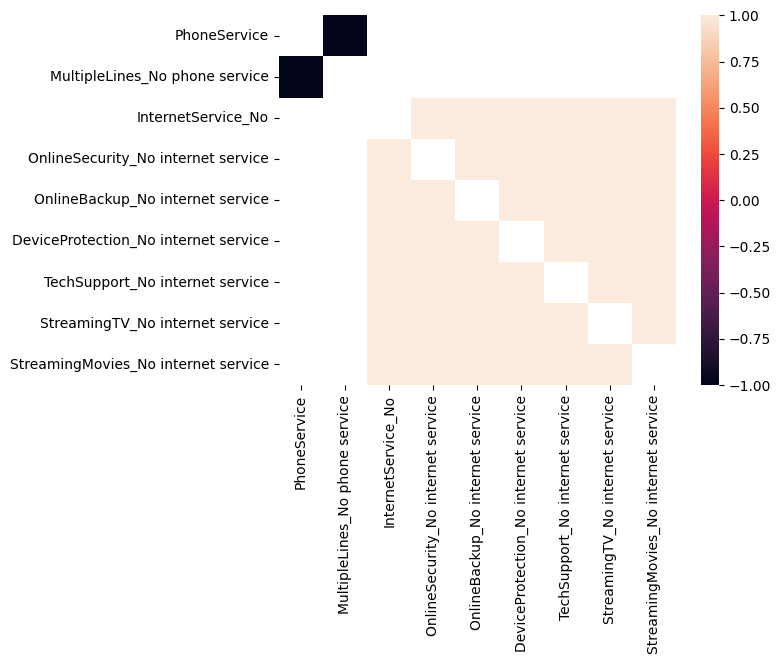

In [20]:
np.fill_diagonal(cm.to_numpy(), 0)
cm_thresh = cm[(cm > 0.85) | (cm <-0.85)]
cm_thresh = cm_thresh.dropna(how='all')
cm_thresh = cm_thresh.dropna(how='all', axis=1)
_ = sns.heatmap(cm_thresh)

In [21]:
cm_thresh.columns

Index(['PhoneService', 'MultipleLines_No phone service', 'InternetService_No',
       'OnlineSecurity_No internet service',
       'OnlineBackup_No internet service',
       'DeviceProtection_No internet service',
       'TechSupport_No internet service', 'StreamingTV_No internet service',
       'StreamingMovies_No internet service'],
      dtype='object')

Here we can see that: 
1. The presence or absence of Internet service is correlated to the analogous value in a number of categorical features. This correlation is unambiguous and is a redundant coding for the same variable (lack of Internet). We'll remove the associated feature to get a clearer picture of the relationship between the remaining one-hot features, which do not exhibit any strong correlation. 
2. The lack of multiple phone lines is 100% correlated to users who have no phone service. This is also a redundant coding and we'll remove. 

In [22]:
dfm.drop([
    'MultipleLines_No phone service', 
    'OnlineSecurity_No internet service',
    'OnlineBackup_No internet service',
    'DeviceProtection_No internet service',
    'TechSupport_No internet service', 
    'StreamingTV_No internet service',
    'StreamingMovies_No internet service'
    ], axis=1, inplace=True)

**Homesceadisticity**

Here we need residuals, postpone until modeling phase. 

**Normality**

Also need residuals, postpone until modeling phase. 

Categorical variables don't lend themselve to a distributional analysis due to the lack of values and the irrelevance of the ordering. The handful of real-valued predictors we have in `MonthlyCharges`, `tenure` and `TotalCharges` do not follow a Gaussian distribution pattern

**Outliers**

Here we look for any outliers that may have an outside influence on our modeling. Per the above section where we examine distribution, only `tenure` and `MonthlyCharges` appear to be at risk for outliers. 

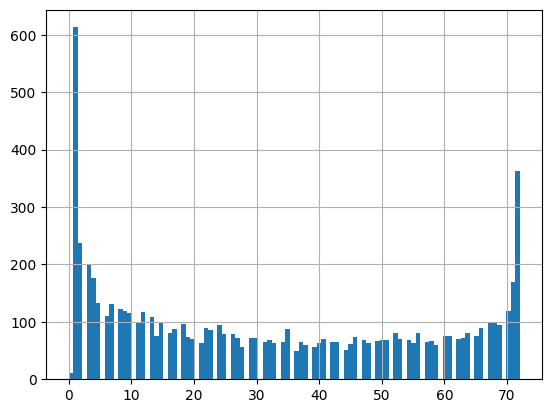

In [23]:
_ = dfm.tenure.hist(bins=100)

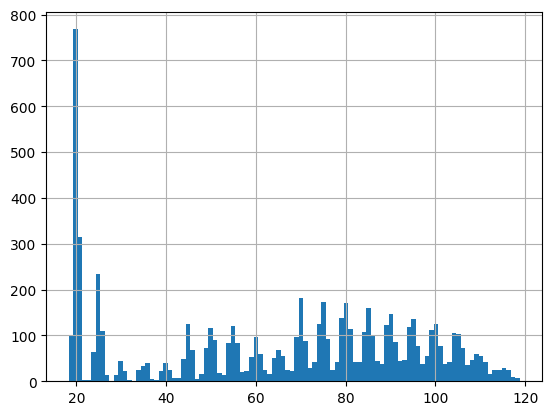

In [24]:
_ = df.MonthlyCharges.hist(bins=100)

The above plots make it clear that we don't have outlier, as odd as the distribution pattern is. We conclude we have met our expectations surrounding outliers and no further cleaning or transformations are required. 

## Modeling

In this section we'll move on to modeling using the conditioned features from above. We consider three models
1. Linear Regression
2. Logistic Regression
3. Generalized Additive Model (GAM)

All models aim to predict the customer `churn` value. We'll first separate our data into predictors we can train on and a target. 

In [447]:
X = dfm.drop(['Churn'], axis=1)
y = dfm.Churn

While linear models are robust to data of varying scales, and scaling introduces a term we must keep track of if we want to understand the impact on our input values, the explainability of our model's learned coefficients suffers if we do not normalize. That is, without a level playing field, we have to individually consider the range and scale of each predictor when we look at learned coefficients. In short, we scale our data here. 

In [448]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

We need to hold data out to later conduct a fair comparison on. Because we don't plan on fine-tuning the parameters of the individual models, we skip the creation of a distinct validation set and just rely on a 80/20 train/test split. 

In [449]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=0.8, random_state=0)

----- 

### Linear Regression

We'll use a linear regression implementation from the Sci-kit Learn library. Specifically we employ the [LinearRegression estimator](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression). 

In [450]:
from sklearn.linear_model import LinearRegression 

model = LinearRegression()
model.fit(X=X_train, y=y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


After fitting we can inspect the learned bias and coefficients for each of our input features: 

In [453]:
model.feature_names_in

AttributeError: 'LinearRegression' object has no attribute 'feature_names_in'

In [451]:
print(f"Fit model equation:\n {model.intercept_:.3f} + ")
for feature, coef in zip(model.feature_names_in_, model.coef_):
    print(f" + {feature} * {coef:.3f}")

Fit model equation:
 0.266 + 


AttributeError: 'LinearRegression' object has no attribute 'feature_names_in_'

To appreciate the suitability of the fit model, we start by charting the predictions and residual errors on the *training data*. This helps us appreciate the impact of model bias.

In [372]:
y_pred = model.predict(X_test)

We can naively compare our predictor to our output class

Text(0.5, 1.0, 'Target vs Predicted Customer Churn,\nLinear Regression Model')

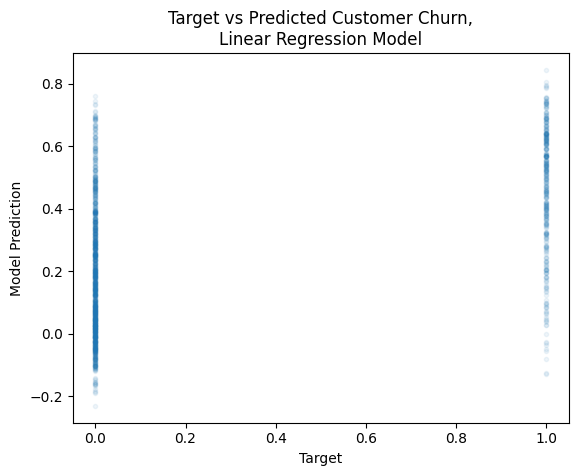

In [376]:
plt.scatter(x=y_test, y=y_pred, marker='.', alpha=0.07)
plt.xlabel('Target')
plt.ylabel('Model Prediction')
plt.title('Target vs Predicted Customer Churn,\nLinear Regression Model')

This is a suboptimal way to interpret our predictions given the density of the plots. However, the transparency suggests we have a problem: Even with thoughtful thresholding of the output value we have significant overlap in the positive and negative classes that we're predicting. 

Looking at the distribution of the predictions reinforces our instinct. There aren't two clear modes we can bisecting with a simple threshold for positive and negative churn predictions. 

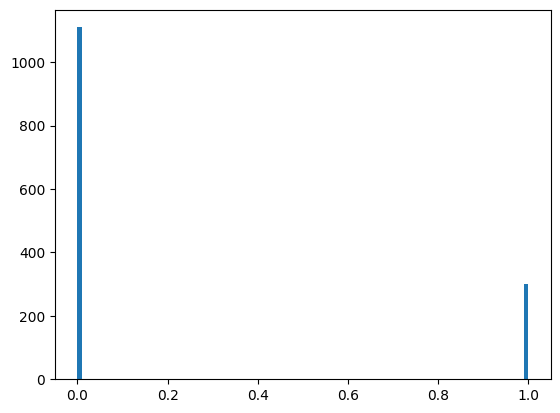

In [433]:
_ = plt.hist(y_pred, bins=100)

Still, we can examine what is essentially a binary classifier by looking at how the true positive and false positive rates shift with a varying threshold and report the area under the receiver operator characteristics (ROC) curve. 

In [378]:
from sklearn.metrics import roc_auc_score

score = roc_auc_score(y_test, y_pred)
print(f"ROC AUC Score: {score:.3f}")

ROC AUC Score: 0.815


And then plot the curve to get an instinct for the how the threshold changes our true + false positive rates. 

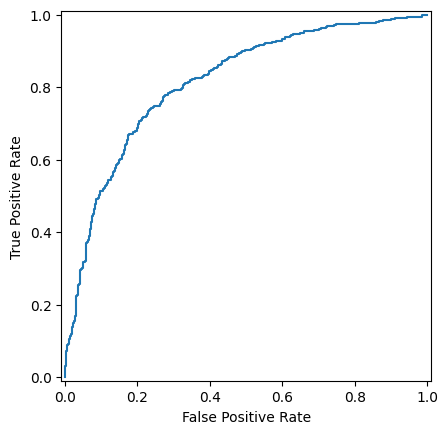

In [379]:
# Note ROC curve interface syntax courtesy of docs @ https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_display_object_visualization.html#sphx-glr-auto-examples-miscellaneous-plot-display-object-visualization-py
fpr, tpr, _ = roc_curve(y_test, y_pred)
rcd = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

Given the characteristic bulge in the curve at the midpoint of the curve, we select a threshold of 0.5 to balance our classifier/regression and check the confusion matrix. 

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_curve, RocCurveDisplay

def threshold_predictions(preds, threshold=0.5): 
    """
    Threshodl the provided predictions and return the new positive and negative classes
    """
    result = np.zeros(len(preds))
    result[preds >= threshold] = 1.0
    return result

def plot_confusion_matrix(y, y_hat): 
    """
    Render a confusion matrix 
    """
    conmat = confusion_matrix(y, y_hat)
    cmd = ConfusionMatrixDisplay(confusion_matrix=conmat)
    cmd.plot()

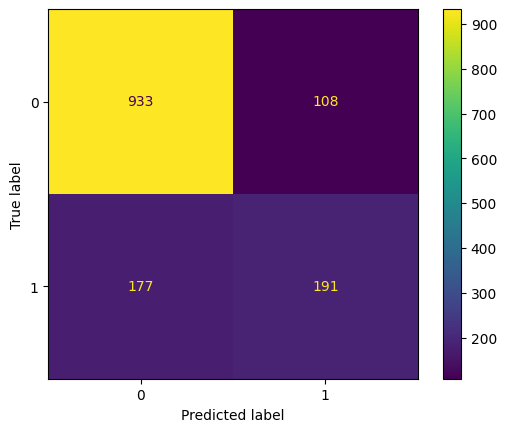

In [438]:
y_binary_pred = threshold_predictions(y_pred, threshold=0.4)
plot_confusion_matrix(y_test, y_binary_pred)

At our selected threshold, the regression estimator is our baseline for performance. We'll use the F1 score, which captures the precision and recall of the model and can be applied to the output of the subsequent models.

In [441]:
f1 = f1_score(y_test, y_binary_pred)
print(f"F1 score for linear regression @ threshold: {f1:.3f}")

F1 score for linear regression @ threshold: 0.573


Finally, we look at the distribution of our residual errors and how residuals move with our predicted value. 

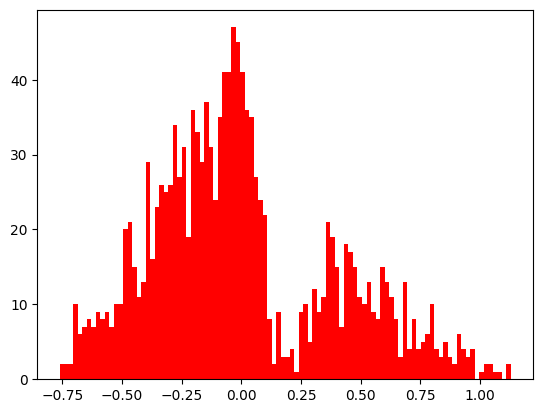

In [384]:
errors = y_test - y_pred
_ = plt.hist(errors, bins=100, color='r')

Text(0, 0.5, 'Prediction Error')

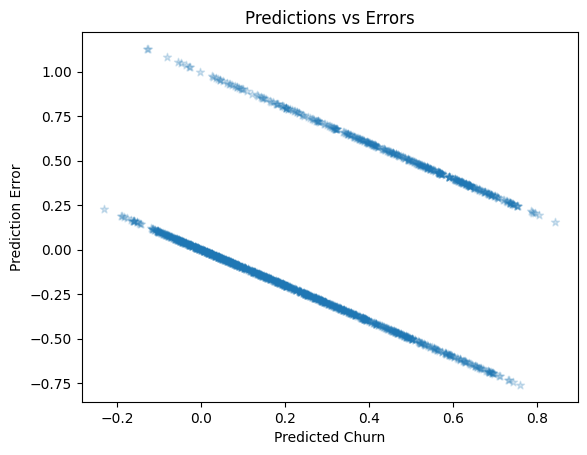

In [387]:
plt.scatter(x=y_pred, y=errors, marker="*", alpha=0.2)
plt.title("Predictions vs Errors")
plt.xlabel("Predicted Churn")
plt.ylabel("Prediction Error")

#### Interpretation

Our model has a straightforward list of coefficients we can evaluate. The dominant factors in the model that contribute to customer churn are 
1. Those who pay by electronic check (0.058)
Fit model equation:
 0.254 + 
 + gender * -0.009
 + SeniorCitizen * 0.047
 + Partner * -0.005
 + Dependents * -0.028
 + tenure * -0.002
 + PhoneService * -0.031
 + PaperlessBilling * -0.046
 + MonthlyCharges * 0.002
 + TotalCharges * -0.000
 + MultipleLines_No * -0.040
 + MultipleLines_Yes * 0.009
 + InternetService_DSL * -0.046
 + InternetService_Fiber optic * 0.065
 + InternetService_No * -0.019
 + OnlineSecurity_No * 0.038
 + OnlineSecurity_Yes * -0.019
 + OnlineBackup_No * 0.033
 + OnlineBackup_Yes * -0.014
 + DeviceProtection_No * 0.015
 + DeviceProtection_Yes * 0.004
 + TechSupport_No * 0.037
 + TechSupport_Yes * -0.019
 + StreamingTV_No * -0.009
 + StreamingTV_Yes * 0.027
 + StreamingMovies_No * 0.001
 + StreamingMovies_Yes * 0.017
 + Contract_Month-to-month * 0.062
 + Contract_One year * -0.053
 + Contract_Two year * -0.009
 + PaymentMethod_Bank transfer (automatic) * -0.014
 + PaymentMethod_Credit card (automatic) * -0.026
 + PaymentMethod_Electronic check * 0.058
 + PaymentMethod_Mailed check * -0.017

In [393]:
def plot_preds(y, y_hat, title=None, n=1000): 
    """
    Plot the first n estimates of target value y 
    """
    samples = range(0,len(y_hat[0:n]))
    errors = y[0:n] - y_hat[0:n]
    plt.figure(figsize=(12,6))
    plt.scatter(x=samples, y=y[0:n], marker='.', label="target", alpha=0.6)
    plt.scatter(x=samples, y=y_hat[0:n], marker='.', label="prediction")
    plt.scatter(x=samples, y=errors, marker='x', color='r', label="error", alpha=0.5)
    plt.title(title)
    plt.legend()
    plt.show()


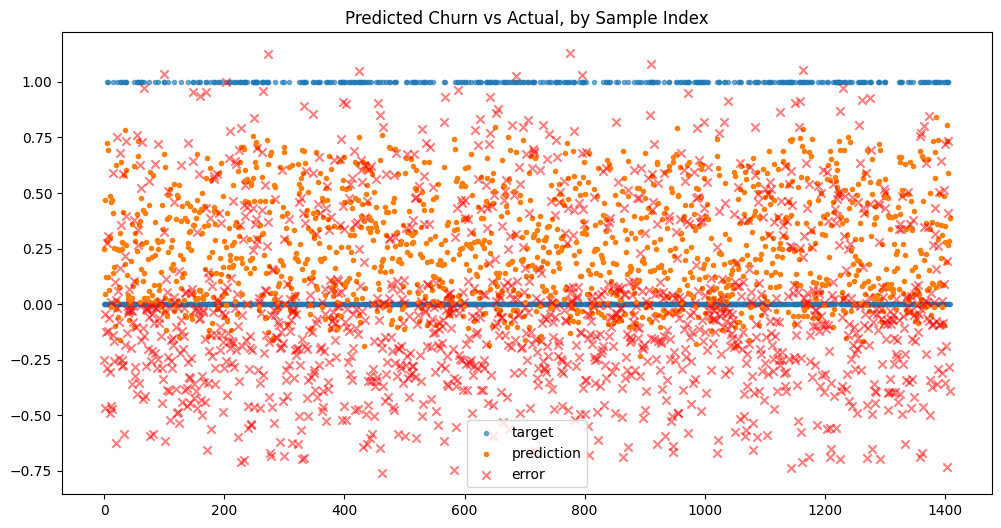

In [394]:
plot_preds(y_test, y_pred, title='Predicted Churn vs Actual, by Sample Index', n=1500)

While intuitively it feels like linear regression is the wrong model for what amounts to a binary classification task, the model does a reasonable job of predicting `churn` if we allow for thresholding of the output to determine the actual prediction. Additionally, the straightforward coefficients we can extract from the model are intuitive and easy to apply to reverse engineer relative importance. 

However, we return to our prerequisites:  
- **Linearity**: Our predictors don't have a clearly linear relationship to the predictor as shown above
- **Independence**: Our observations do appear to be independent and uncorrelated
- **Homoscedacicity**: The variance of our residuals do not seem to move with the prediction, so homoscedacity is upheld
- **Collinearity**: Our observations do not appear to be collinear and are uncorrelated
- **Normality** We have perhaps two distinct gaussian distributions of the residuals, which seems to undermine of the prerequisites 
- **Outliers** Above distributional plots did not indicate presence of influential outliers

This mixed scorecard suggests linear regression is not the optimal algorithm to apply without further interventions. 

----- 

### Logistic Regression 

For logistic regression, we'll use the [logistic regression estimator from Sci-kit Learn](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression). 

In [400]:
from sklearn.linear_model import LogisticRegression

In [401]:
model = LogisticRegression()
model.fit(X=X_train, y=y_train)

/Users/jason/Local/school/590/assignment2/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [416]:
print(f"Fit model equation:\n {model.intercept_[0]:.3f} + ")
for feature, coef in zip(model.feature_names_in_, model.coef_.flatten()):
    print(f" + {feature} * {coef:.3f}")

Fit model equation:
 -0.225 + 
 + gender * -0.075
 + SeniorCitizen * 0.266
 + Partner * -0.067
 + Dependents * -0.282
 + tenure * -0.061
 + PhoneService * -0.340
 + PaperlessBilling * -0.414
 + MonthlyCharges * 0.006
 + TotalCharges * 0.000
 + MultipleLines_No * -0.307
 + MultipleLines_Yes * -0.033
 + InternetService_DSL * -0.261
 + InternetService_Fiber optic * 0.288
 + InternetService_No * -0.249
 + OnlineSecurity_No * 0.237
 + OnlineSecurity_Yes * -0.211
 + OnlineBackup_No * 0.168
 + OnlineBackup_Yes * -0.142
 + DeviceProtection_No * 0.029
 + DeviceProtection_Yes * -0.003
 + TechSupport_No * 0.229
 + TechSupport_Yes * -0.203
 + StreamingTV_No * -0.121
 + StreamingTV_Yes * 0.148
 + StreamingMovies_No * -0.045
 + StreamingMovies_Yes * 0.071
 + Contract_Month-to-month * 0.461
 + Contract_One year * -0.262
 + Contract_Two year * -0.421
 + PaymentMethod_Bank transfer (automatic) * -0.105
 + PaymentMethod_Credit card (automatic) * -0.225
 + PaymentMethod_Electronic check * 0.263
 + Paymen

In [420]:
y_pred = model.predict(X_test)

We can apply the same plot of target value vs predicted and the prediction distrubiotn as with linear regression.  

Text(0.5, 1.0, 'Target vs Predicted Customer Churn,\nLogistic Regression Model')

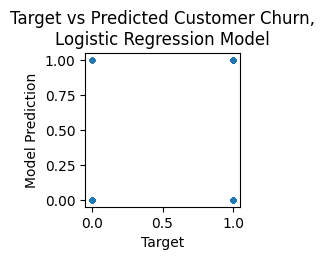

In [430]:
plt.figure(figsize=(2,2))
plt.scatter(x=y_test, y=y_pred, marker='.', alpha=0.07)
plt.xlabel('Target')
plt.ylabel('Model Prediction')
plt.title('Target vs Predicted Customer Churn,\nLogistic Regression Model')

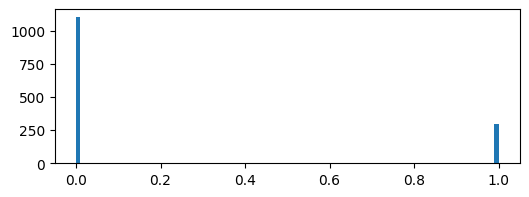

In [435]:
plt.figure(figsize=(6,2))
_ = plt.hist(y_pred, bins=100)

However, these are of little use given the binary output of the logistic regression model. Instead we investigate the confusion matrix as with our thresholded regression estimator. 

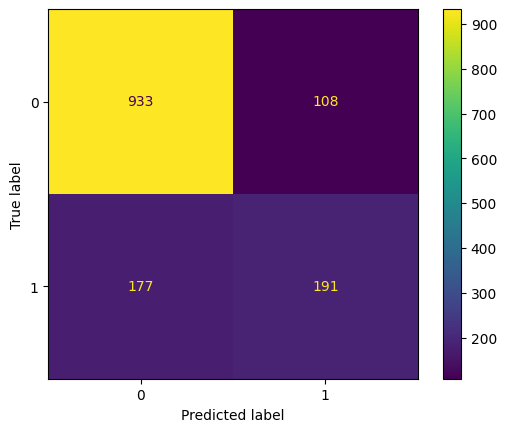

In [436]:
plot_confusion_matrix(y_test, y_pred) 

In [444]:
f1 = f1_score(y_test, y_pred)
print(f"F1 score for logistic regression: {f1:.3f}")

F1 score for logistic regression: 0.573


#### Interpretation

Logistic regression's incorporation of a non-linear transformation on the linear model's output significantly improves the aligment with the prediction task here. 

----- 

### Generalized Additive Model 

The generalized additive model (GAM) implementation comes from the Python [`pygam` library](https://pygam.readthedocs.io/en/latest/). 

In [33]:
from pygam import LinearGAM, s

In [ ]:
splines = s(0)
for i in range(1, X_train.shape[1]): 
    splines = splines + s(i) 

gam = LinearGAM(splines)

In [35]:
gam.gridsearch(train.to_numpy(), target.to_numpy())

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:02 ETA:   0:00:21
 18% (2 of 11) |####                     | Elapsed Time: 0:00:04 ETA:   0:00:18
 27% (3 of 11) |######                   | Elapsed Time: 0:00:06 ETA:   0:00:16
 36% (4 of 11) |#########                | Elapsed Time: 0:00:08 ETA:   0:00:14
 45% (5 of 11) |###########              | Elapsed Time: 0:00:10 ETA:   0:00:12
 54% (6 of 11) |#############            | Elapsed Time: 0:00:12 ETA:   0:00:10
 63% (7 of 11) |###############          | Elapsed Time: 0:00:14 ETA:   0:00:08
 72% (8 of 11) |##################       | Elapsed Time: 0:00:16 ETA:   0:00:06
 81% (9 of 11) |####################     | Elapsed Time: 0:00:19 ETA:   0:00:04
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:21 ETA:   0:00:02
100% (11 of 11) |########################| Elapsed Time: 0:00:23 Time:  0:00:23


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12) + s(13) + s(14) + s(15) + s(16) + s(17) + s(18) + s(19) + s(20) + s(21) + s(22) + s(23) + s(24) + s(25) + s(26) + s(27) + s(28) + s(29) + s(30) + s(31) + s(32) + intercept,
   tol=0.0001, verbose=False)

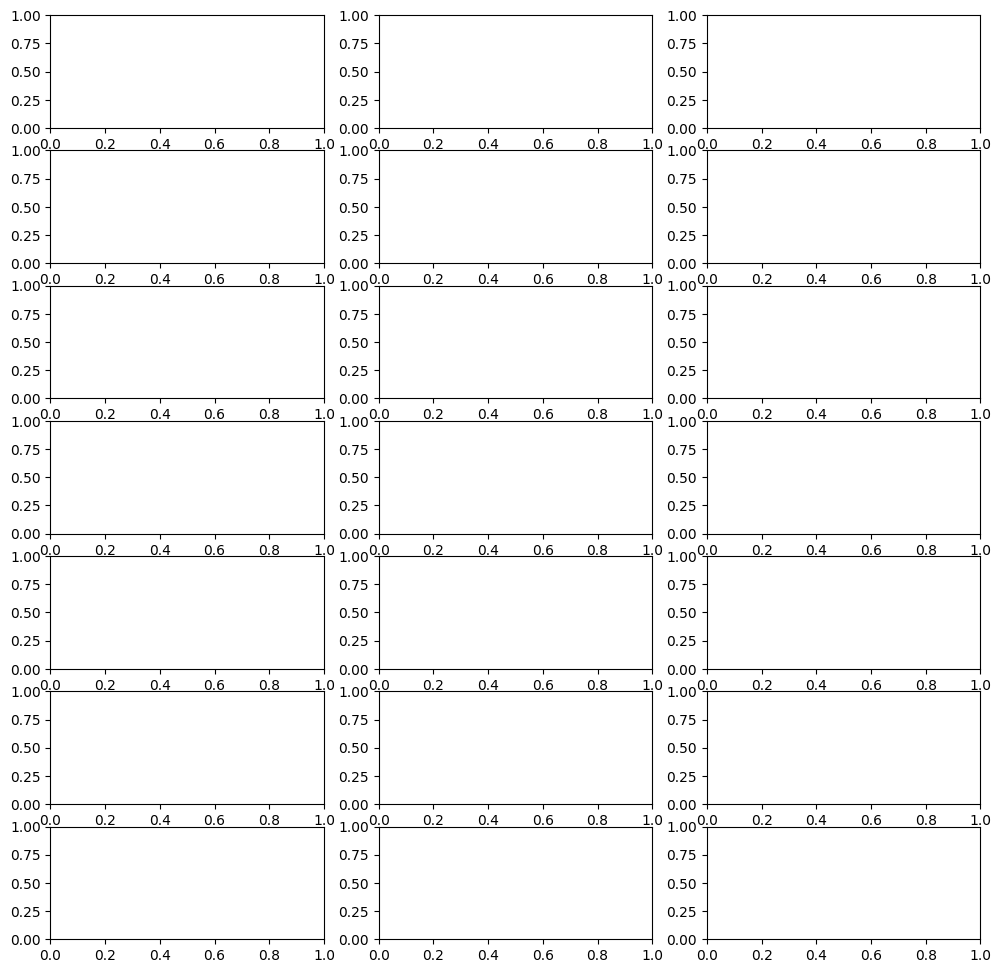

In [36]:
features = df.columns
h = 7
w = 3
fig, axs = plt.subplots(h,w, figsize=(12,12))

In [37]:
plot_columns = train.columns

<Figure size 640x480 with 0 Axes>

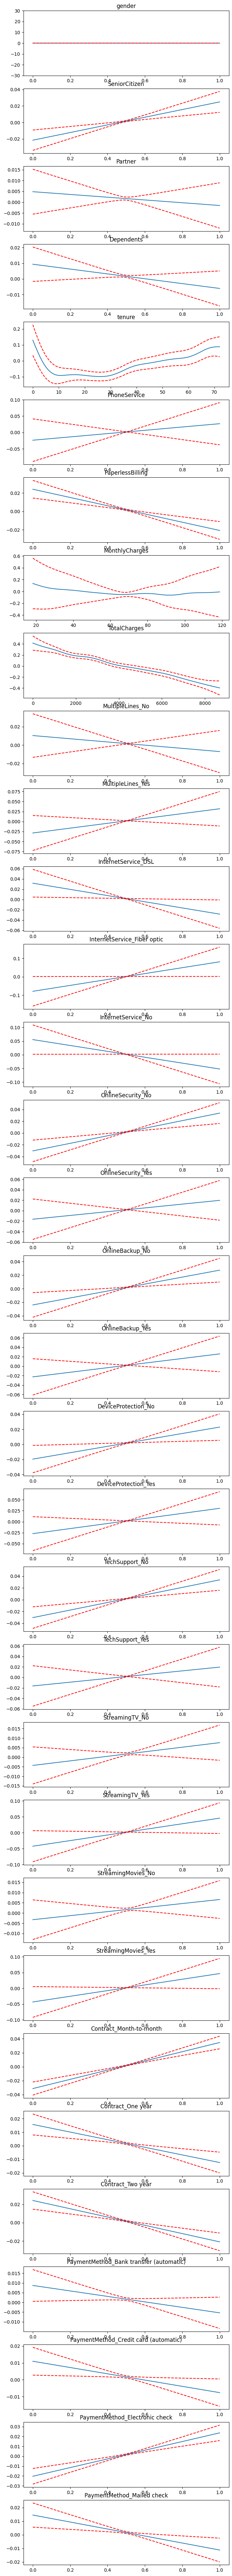

In [38]:

# Code snippet mined from PyGAM documentation here: https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html#Regression

plt.figure()
fig, axs = plt.subplots(len(plot_columns),1, figsize=(8,100))

for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(plot_columns[i]);


In [39]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     44.1451
Link Function:                     IdentityLink Log Likelihood:                                -18299.1018
Number of Samples:                         7043 AIC:                                            36688.4937
                                                AICc:                                           36689.0892
                                                GCV:                                                0.1365
                                                Scale:                                              0.1349
                                                Pseudo R-Squared:                                   0.3122
Feature Function                  Lam

/var/folders/t0/vjz2r6l1155639x6cpfr8z3h0000gn/T/ipykernel_56658/3358381670.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


#### Interpretation

## Comparison of Models

Ultimately, our goal is to predict `churn`, but we must also be able to defend the model's predictions, make sense of it when it falls short of expectations, and explain its operation to our customer. 

**Linear Regression**

- 
- 

**Logistic Regression** 

- 

**Generalized Additive Model** 

- TODO:  Model Comparison: Compare the performance and interpretability of the different models you built. Discuss the strengths and weaknesses of each approach and provide recommendations for which model(s) the telecommunications company should use to address their customer churn problem.
    


## Recommendation 

As the company desires to not just predict customer churn, but understand the factors that lead to customer churn, we must not just consider the model's ability to perform, but how we can communicate its operation. Thus, a balanced